In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as p
from utils import *lt
plt.rcParams['figure.figsize'] = (10, 8)

# Load data

In [2]:
air_passengers = pd.read_csv('data/AirPassengers.csv')
display(air_passengers.head())
air_passengers.info()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
air_passengers = air_passengers.set_index(pd.to_datetime(air_passengers["Month"])).drop(columns=["Month"]).rename(columns={'#Passengers': 'passengers'})
air_passengers.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


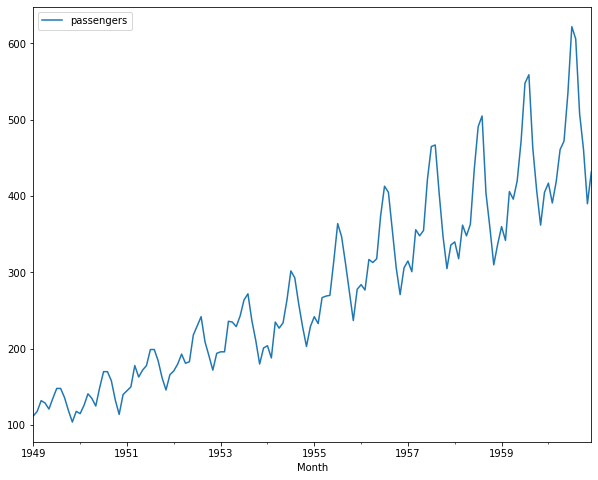

In [4]:
air_passengers.plot()
plt.show()

# Stationarity

## ADfuller test

In [5]:
from statsmodels.tsa.stattools import adfuller
adfuller(air_passengers, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(0.8153688792060543,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [6]:
 
    )
    

adf_test(air_passengers)

Is the time series stationary? False
test statistic value = 0.82
p value = 0.99
test critical values (5%) = -2.88


Is the time series stationary? False
test statistic value = -1.72
p value = 0.42
test critical values (5%) = -2.88


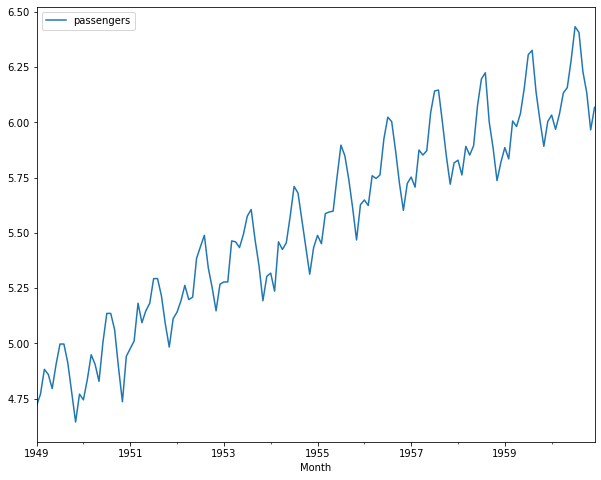

In [7]:
airpassenger_without_exp_growth = np.log(air_passengers)
adf_test(airpassenger_without_exp_growth)
airpassenger_without_exp_growth.plot()
plt.show()

In [8]:
airpassenger_without_exp_growth.head()

,passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


Is the time series stationary? False
test statistic value = -2.72
p value = 0.07
test critical values (5%) = -2.88


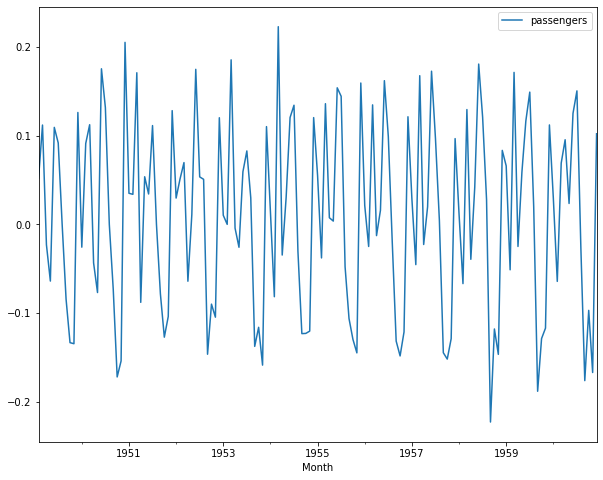

In [9]:
air_passengers_log_1_diff = airpassenger_without_exp_growth.diff().dropna()
adf_test(air_passengers_log_1_diff)
air_passengers_log_1_diff.plot()
plt.show()

While the p value is slightly over 0.05, we wil use the **air_passengers_log_1_diff** data as our input for the modelisation and prediction part.

# Determine if the series is AutoRegressive (AR)

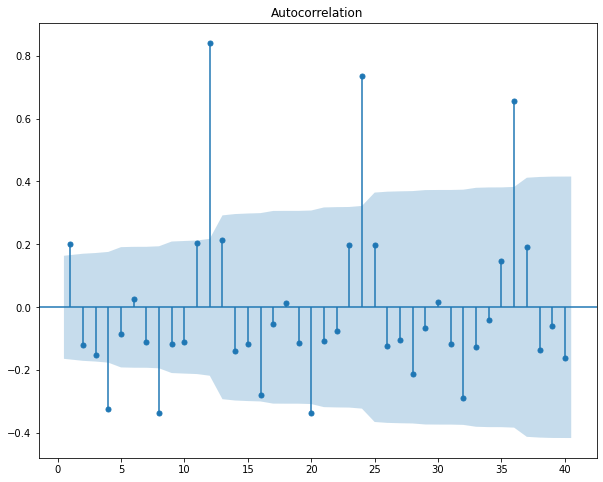

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

air_passengers_stationary = air_passengers_log_1_diff
acf = plot_acf(air_passengers_stationary, zero=False, lags=40)

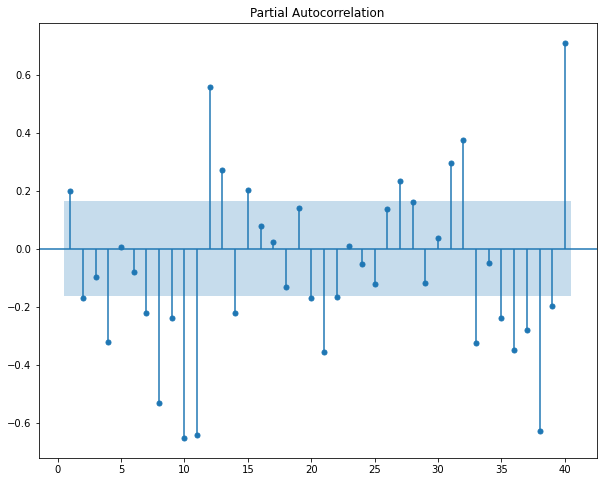

In [11]:
pacf = plot_pacf(air_passengers_stationary, zero=False, lags=40)

## Analisys

Using the ACF and PACF plots, we can deduce that this time series is not AutoRegressive.  
Indeed, the ACF doesn't really cut off after a certain number of lags.  
The same way, the PACF doesn't not have a decreasing trend.

# Modelisation
Split train and test data

In [12]:
X_train = air_passengers_stationary['1945-01-01': '1957-12-01']
X_test = air_passengers_stationary['1958-01-01': '1960-12-01']

## AR Model
### First try with low order (5)

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(endog=X_train, order=(5, 0, 0))
fitted_model = model.fit()

C:\Users\je2f_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\je2f_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\je2f_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [14]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  107
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 101.160
Date:                Sat, 31 Jul 2021   AIC                           -188.319
Time:                        23:25:09   BIC                           -169.609
Sample:                    02-01-1949   HQIC                          -180.734
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0111      0.007      1.505      0.132      -0.003       0.025
ar.L1          0.1732      0.107      1.616      0.106      -0.037       0.383
ar.L2         -0.2418      0.119     -2.037      0.042      -0.474      -0.009
ar.L3         -0.0117      0.102     -0.115      0.908      -0.212       0.188
ar.L4         -0.3531      0.091     -3.860      0.000      -0.532      -0.174
ar.L5          0.0030      0.133      0.023      0.982      -0.259       0.265
sigma2         0.0088      0.002      4.392      0.000       0.005       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.12
Prob(Q):                              0.99   Prob(JB):                         0.03
Heteroskedasticity (H):               0.97   Skew:                             0.26
Prob(H) (two-sided):                  0.92   Kurtosis:                         1.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

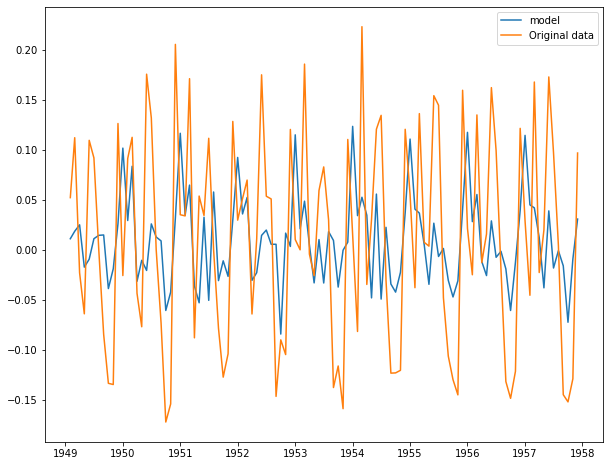

In [15]:
import matplotlib.pyplot as plt
plt.plot(fitted_model.fittedvalues[:], label='model')
plt.plot(X_train, label='Original data')
plt.legend()
plt.show()

We can see that the model with this order is quite bad on the train data so we will train a higher order model.

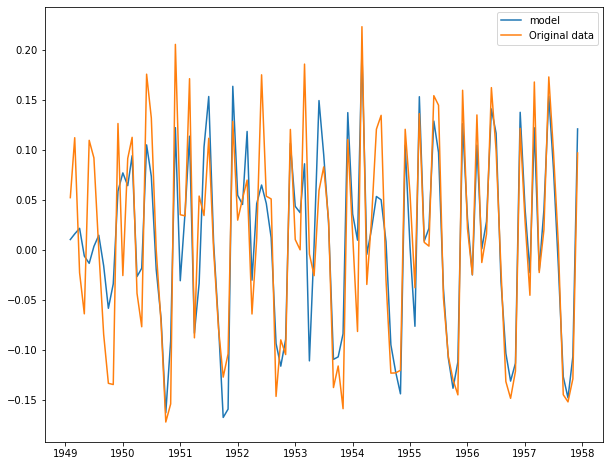

In [16]:
%%capture --no-display 
import time
#(hide warning messages for readability)
order_AR = 13
model = ARIMA(endog=X_train, order=(order_AR, 0, 0))

start = time.time()
fitted_model = model.fit()
fit_time = time.time() - start

plt.plot(fitted_model.fittedvalues[:], label='model')
plt.plot(X_train, label='Original data')
plt.legend()
plt.show()



Now we have a good fit at least at the end of the period. We can print the residuals:

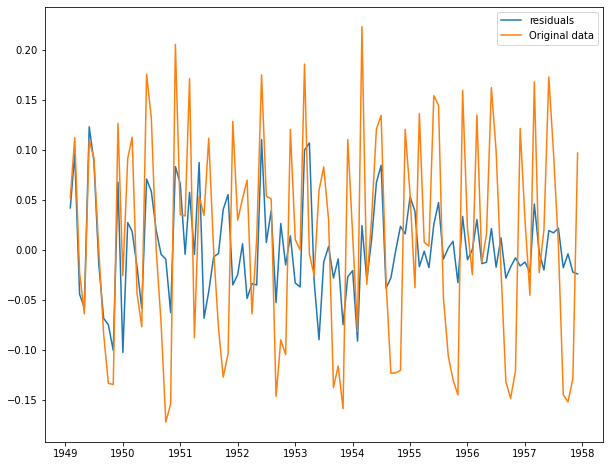

In [17]:
train_pred = pd.DataFrame(fitted_model.fittedvalues, columns=['passengers'])
plt.plot(X_train - train_pred, label='residuals')
plt.plot(X_train, label='Original data')
plt.legend()
plt.show()


## Multistep forecasting

In [18]:
preds = fitted_model.predict(start=X_test.index[0], end=X_test.index[-1]).to_frame('passengers')

C:\Users\je2f_\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [19]:
preds.head()

,passengers
1958-01-01,0.039945
1958-02-01,-0.038604
1958-03-01,0.136792
1958-04-01,-0.004340
1958-05-01,0.036575


In [20]:
from sklearn.metrics import mean_absolute_percentage_error
mape_score = mean_absolute_percentage_error(X_test, preds)
print(f'MAPE score: {mape_score:.4f}')
mape_score_records = {'AR_model': {'all_forecast_one': mape_score}}
mape_score_records['AR_model']['AIC'] = fitted_model.aic 
mape_score_records['AR_model']['BIC'] = fitted_model.bic 
mape_score_records['AR_model']['fit_time'] = fit_time

MAPE score: 0.5141


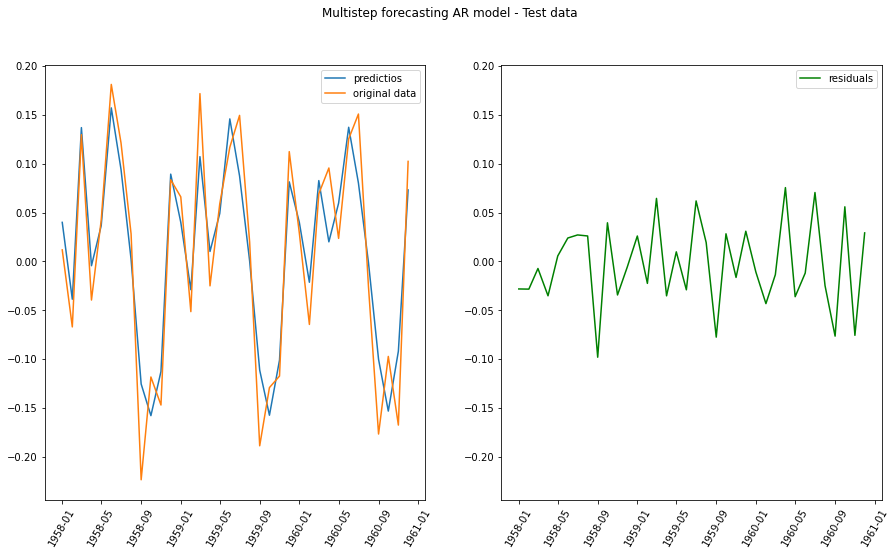

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,8), sharey=True)

ax[0].plot(preds, label='predictios')
ax[0].plot(X_test, label='original data')
ax[1].plot(X_test - preds, label='residuals', c='g')
fig.suptitle('Multistep forecasting AR model - Test data')
ax[0].legend()
ax[1].legend()
ax[0].tick_params(axis='x', labelrotation=60)
ax[1].tick_params(axis='x', labelrotation=60)
ax[1].tick_params(labelleft=True)

plt.show()

## Expanding window

### One step forecasting

In [22]:
%%time

import warnings
warnings.simplefilter('ignore')

# params:
window = 1

predictions = expanding_window(window, (order_AR, 0, 0), X_train, X_test)

warnings.simplefilter("always")

100%|██████████| 35/35 [00:55<00:00,  1.58s/it]Wall time: 56.6 s



C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

MAPE score: 0.4506


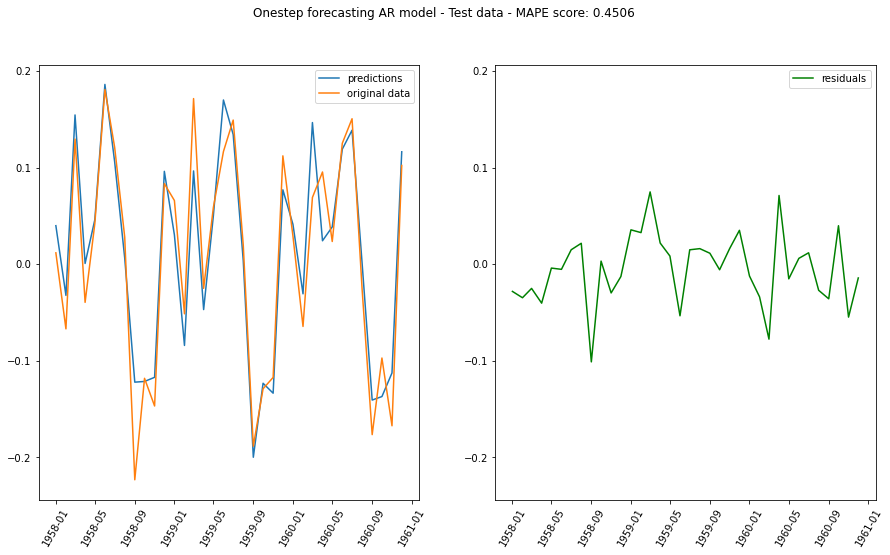

In [23]:
mape_score_records['AR_model']['one_step'] = score_and_plot(X_test, predictions, 'Onestep forecasting AR model - Test data')


### Multistep forecasting (window=3)

In [24]:
import warnings
warnings.simplefilter('ignore')

# params:
window = 3
order_AR =13
order_diff = 0
order_MA = 0

predictions = expanding_window(window, (order_AR, order_diff, order_MA), X_train, X_test)

warnings.simplefilter("always")

C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

MAPE score: 0.4435


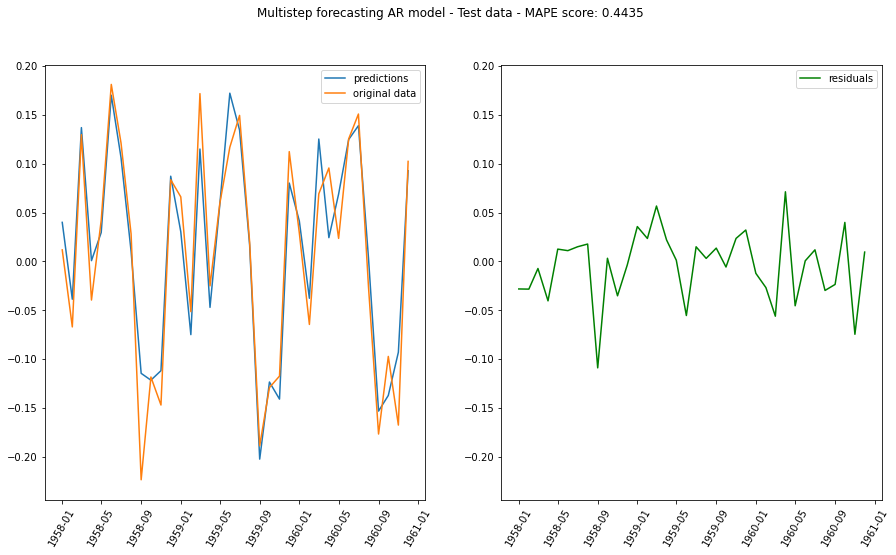

In [25]:
mape_score_records['AR_model']['multi_step'] = score_and_plot(X_test, predictions, 'Multistep forecasting AR model - Test data')

## MA model

### All Forecasting at once

C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

MAPE score: 0.9094


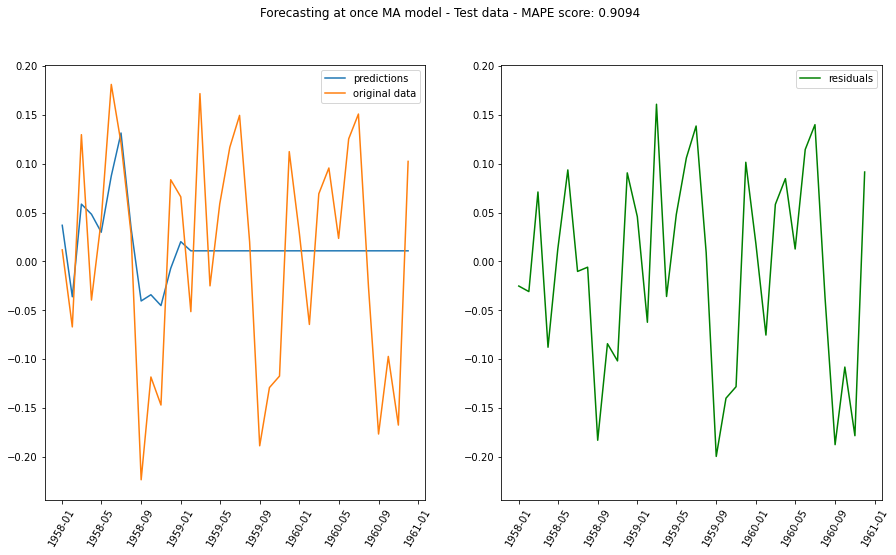

In [26]:
import warnings
warnings.simplefilter('ignore')
order_MA = 13

model = ARIMA(endog=X_train, order=(0, 0, order_MA))

start = time.time()
fitted_model = model.fit()
fit_time = time.time() - start

preds = fitted_model.predict(start=X_test.index[0], end=X_test.index[-1]).to_frame('passengers')
mape_score_records['MA_model'] = {'all_forecast_one': score_and_plot(X_test, preds, 'Forecasting at once MA model - Test data')} 
mape_score_records['MA_model']['AIC'] = fitted_model.aic 
mape_score_records['MA_model']['BIC'] = fitted_model.bic 
mape_score_records['MA_model']['fit_time'] = fit_time


In [27]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  107
Model:                ARIMA(0, 0, 13)   Log Likelihood                 137.244
Date:                Sat, 31 Jul 2021   AIC                           -244.489
Time:                        23:26:37   BIC                           -204.396
Sample:                    02-01-1949   HQIC                          -228.236
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0109      0.001      9.030      0.000       0.009       0.013
ma.L1          0.0549      0.402      0.137      0.891      -0.734       0.844
ma.L2         -0.1319      0.483     -0.273      0.785      -1.079       0.815
ma.L3         -0.2001      0.485     -0.413      0.680      -1.151       0.750
ma.L4         -0.2514      0.597     -0.421      0.674      -1.422       0.919
ma.L5         -0.2482      0.489     -0.508      0.612      -1.206       0.710
ma.L6         -0.1367      0.235     -0.582      0.560      -0.597       0.323
ma.L7         -0.0981      0.493     -0.199      0.842      -1.065       0.869
ma.L8         -0.4423      0.712     -0.622      0.534      -1.837       0.952
ma.L9         -0.0901      0.560     -0.161      0.872      -1.188       1.008
ma.L10        -0.2675      0.480     -0.557      0.578      -1.209       0.674
ma.L11        -0.2556      0.552     -0.463      0.643      -1.337       0.826
ma.L12         0.6391      0.591      1.081      0.279      -0.519       1.797
ma.L13         0.4743      0.439      1.081      0.280      -0.386       1.335
sigma2         0.0036      0.003      1.285      0.199      -0.002       0.009
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):                 2.89
Prob(Q):                              0.27   Prob(JB):                         0.24
Heteroskedasticity (H):               0.83   Skew:                             0.29
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### One step Forecasting

In [28]:
warnings.simplefilter('ignore')

# params:
window = 1


predictions = expanding_window(window, (0, 0, order_MA), X_train, X_test)

warnings.simplefilter("always")

100%|██████████| 35/35 [00:38<00:00,  1.09s/it]


C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

MAPE score: 0.7707


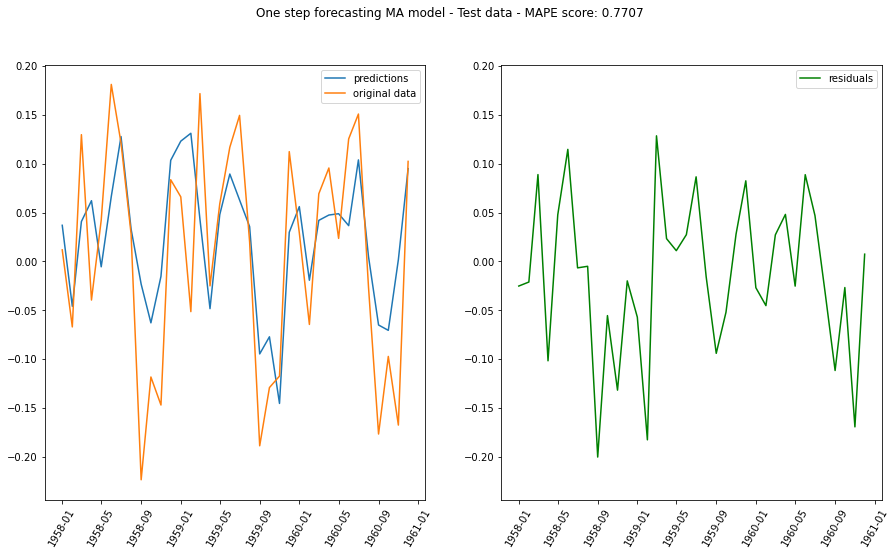

In [29]:
mape_score_records['MA_model']['one_step'] = score_and_plot(X_test, predictions, 'One step forecasting MA model - Test data')

### Multi Step forecasting

In [30]:
import warnings
warnings.simplefilter('ignore')

# params:
window = 3

predictions = expanding_window(window, (0, 0, order_MA), X_train, X_test)

warnings.simplefilter("always")

C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

MAPE score: 0.7158


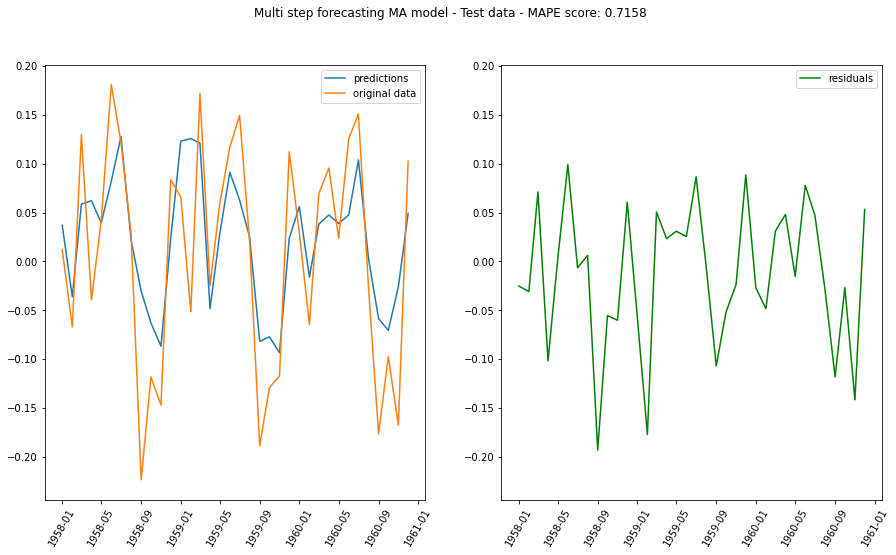

In [31]:
mape_score_records['MA_model']['multi_step'] = score_and_plot(X_test, predictions, 'Multi step forecasting MA model - Test data')

## ARMA model 
### All forecasting at once

C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

MAPE score: 0.4841


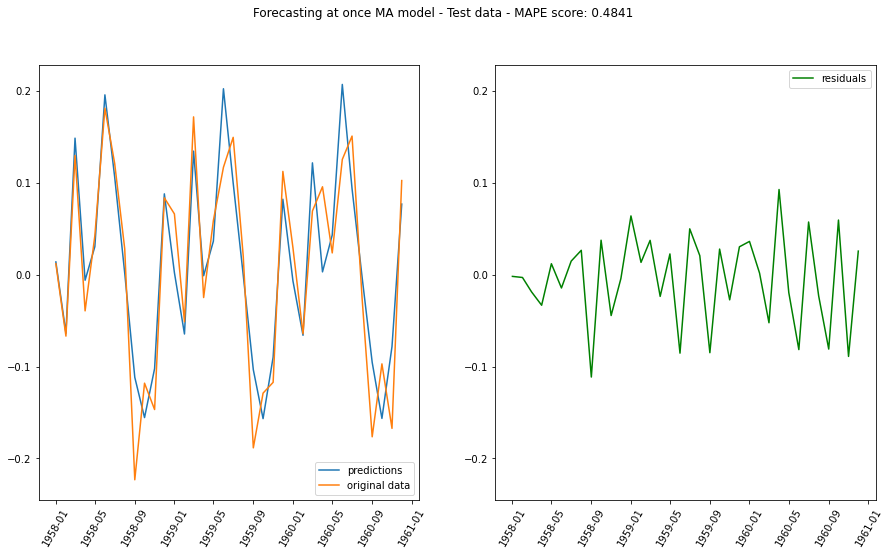

In [32]:
import warnings
warnings.simplefilter('ignore')


model = ARIMA(endog=X_train, order=(order_AR, 0, order_MA))

start = time.time()
fitted_model = model.fit()
fit_time = time.time() - start

preds = fitted_model.predict(start=X_test.index[0], end=X_test.index[-1]).to_frame('passengers')
mape_score_records['ARMA_model'] = {'all_forecast_one': score_and_plot(X_test, preds, 'Forecasting at once MA model - Test data')} 
mape_score_records['ARMA_model']['AIC'] = fitted_model.aic 
mape_score_records['ARMA_model']['BIC'] = fitted_model.bic 
mape_score_records['ARMA_model']['fit_time'] = fit_time

### One Step forecasting

In [33]:
import warnings
warnings.simplefilter('ignore')

# params:
window = 1

predictions = expanding_window(window, (order_AR, 0, order_MA), X_train, X_test)

warnings.simplefilter("always")

100%|██████████| 35/35 [01:41<00:00,  2.90s/it]


C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

MAPE score: 0.4578


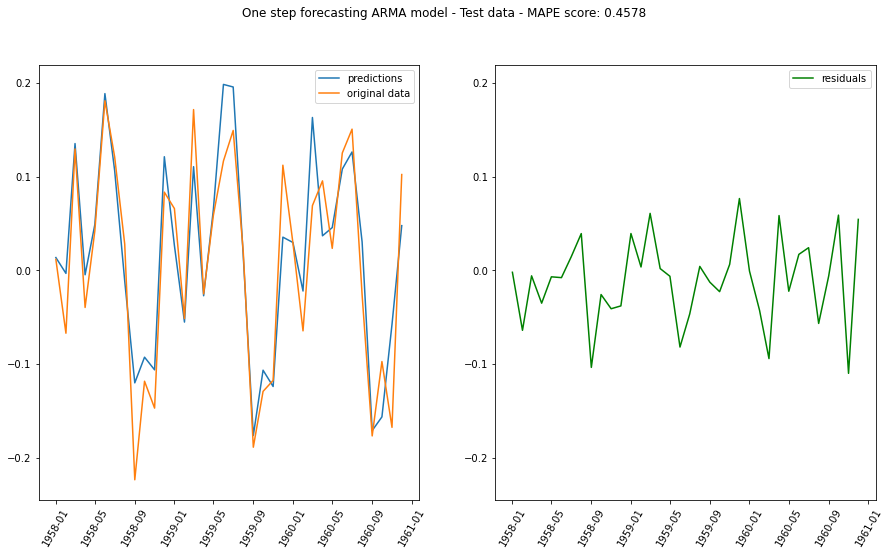

In [34]:
mape_score_records['ARMA_model']['one_step'] = score_and_plot(X_test, predictions, 'One step forecasting ARMA model - Test data')

### Multi Step forecasting

In [50]:
import warnings
warnings.simplefilter('ignore' 5

# params:
window = 3

predictions = expanding_window(window, (order_AR, 0, order_MA), X_train, X_test)

warnings.simplefilter("always")

C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 11/11 [00:38<00:00,  3.51s/it]


C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

MAPE score: 0.4196


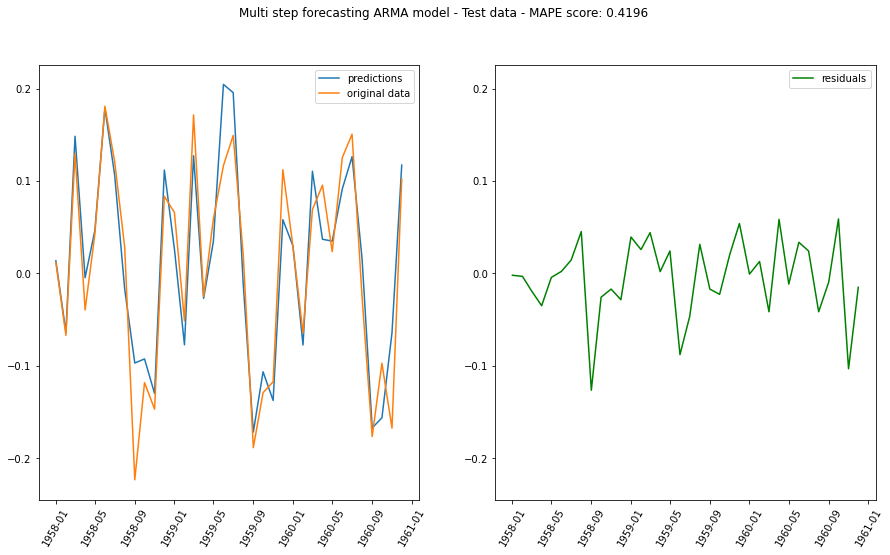

In [51]:
mape_score_records['ARMA_model']['multi_step'] = score_and_plot(X_test, predictions, 'Multi step forecasting ARMA model - Test data')

# Benchmark

In [52]:
kpi_df = pd.DataFrame(mape_score_records).T
kpi_df.head()

C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,all_forecast_one,AIC,BIC,fit_time,one_step,multi_step
AR_model,0.514058,-332.578628,-292.486196,1.157876,0.450596,0.443528
MA_model,0.909406,-244.488578,-204.396146,1.091238,0.770652,0.715769
ARMA_model,0.484090,-320.385628,-245.546421,2.479694,0.457786,0.419560


C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


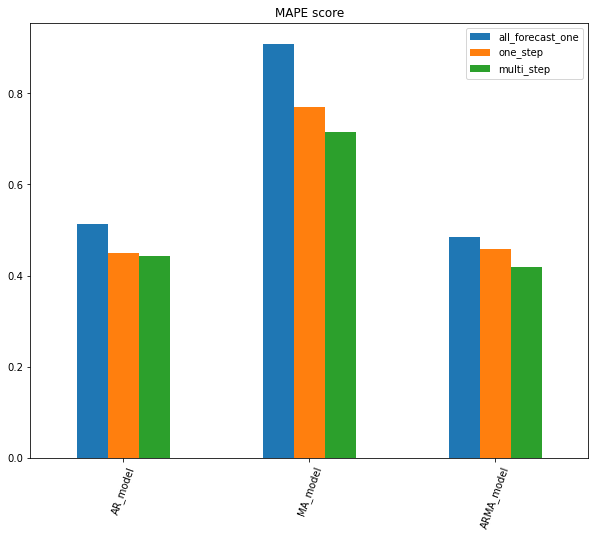

In [53]:
kpi_df[['all_forecast_one', 'one_step', 'multi_step']].plot(kind='bar')
plt.title('MAPE score')
plt.xticks(rotation=70)
plt.show()

C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


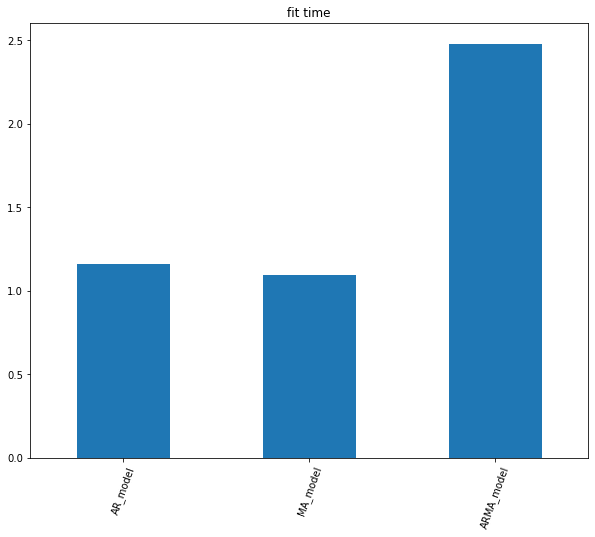

In [54]:
kpi_df['fit_time'].plot(kind='bar')
plt.title('fit time')
plt.xticks(rotation=70)
plt.show()

C:\Users\je2f_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

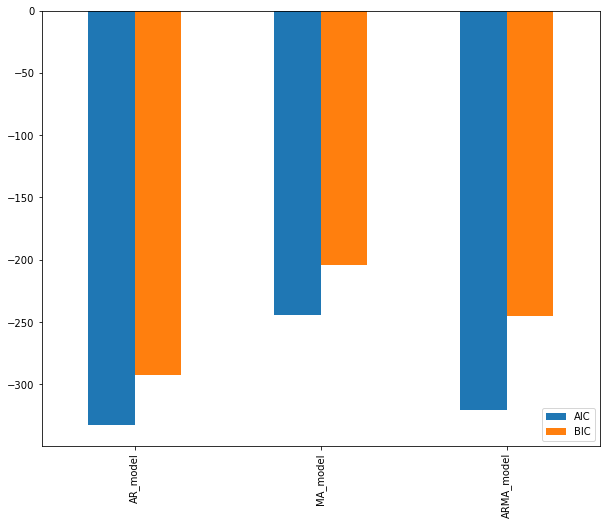

In [56]:
kpi_df[['AIC', 'BIC']].plot(kind='bar')

## Analysis

The model with the best MAPE, is the ARMA model closely followed by AR midel.  
BIC and AIC scores are actually a bit better for the AR model as the model is simpler (less parameters) and has a very close MAPE score.  
AIC and BIC scores need to be minimised even if they are negative.  

We also notice that the multistep prediction is better than the one step.  
It is a bit counter-intuitive that a multistep prediction can be better than a one step one.  

Considering in addition that it means less times where we need to fit the model with new data, it is clearly better to chose the multistep approach.  
We may want to check other windows to see the results.  
Now in order to chose between AR and ARMA model, we need to see the application and how much the fit time is an issue.  
Indeed the scores are very close and it may not be worth the extra computation time.

# Forecast with ARMA model

## One step

In [4]:
import warnings
warnings.simplefilter("ignore")
original_model = ARIMA(endog=X_train, order=(13, 0, 5))
fitted_model = original_model.fit()


NameError: name 'ARIMA' is not defined

In [49]:
one_forecast = fitted_model.get_forecast(steps=1).summary_frame(alpha=.1)
one_forecast = one_forecast.rename(columns={'mean': 'passengers'})
one_forecast.head()


C:\Users\je2f_\anaconda3\envs\donkey\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


passengers,passengers,mean_se,mean_ci_lower,mean_ci_upper
1958-01-01,0.036676,0.042467,-0.033175,0.106527


In [22]:
result = airpassenger_without_exp_growth.copy()
result = result.rename(columns={"passengers": "log_passengers"})
result['original_data'] = air_passengers
result = pd.concat([result, X_train], axis=1)
result.head()


,log_passengers,original_data,passengers
Month,,,
1949-01-01,4.718499,112,NaN
1949-02-01,4.770685,118,0.052186
1949-03-01,4.882802,132,0.112117
1949-04-01,4.859812,129,-0.022990
1949-05-01,4.795791,121,-0.064022


In [68]:
 res

result_one_forecast = add_forecast_data(result, one_forecast)
result_one_forecast['1957-12-01': '1958-03-01']

,log_passengers,original_data,passengers,log_out,scale_out
Month,,,,,
1957-12-01,5.817111,336,0.096799,5.817111,336.000000
1958-01-01,5.828946,340,0.036676,5.853787,348.551938
1958-02-01,5.762051,318,NaN,NaN,NaN
1958-03-01,5.891644,362,NaN,NaN,NaN


In [38]:
   plt.show()

plot_forecast(resut_one_forecast)



## Multi step forecasting

In [65]:
nb_steps = 5

multi_forecast = fitted_model.get_forecast(steps=5).summary_frame(alpha=.1)
multi_forecast = multi_forecast.rename(columns={'mean': 'passengers'})
result_multi_forecast = add_forecast_data(result, multi_forecast)
result_multi_forecast['1957-12-01': '1958-07-01']

C:\Users\je2f_\anaconda3\envs\donkey\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


passengers,passengers,mean_se,mean_ci_lower,mean_ci_upper
1958-01-01,0.036676,0.042467,-0.033175,0.106527
1958-02-01,-0.021145,0.044733,-0.094724,0.052434
1958-03-01,0.145366,0.044878,0.071549,0.219183
1958-04-01,0.006235,0.046032,-0.069480,0.081951
1958-05-01,0.022322,0.047487,-0.055787,0.100431


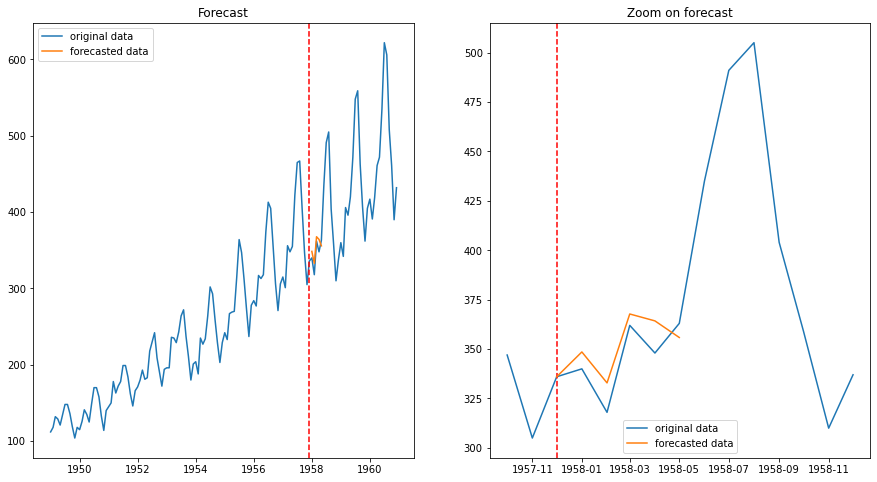

In [108]:
plot_forecast(result_multi_forecast)

## Plot interval

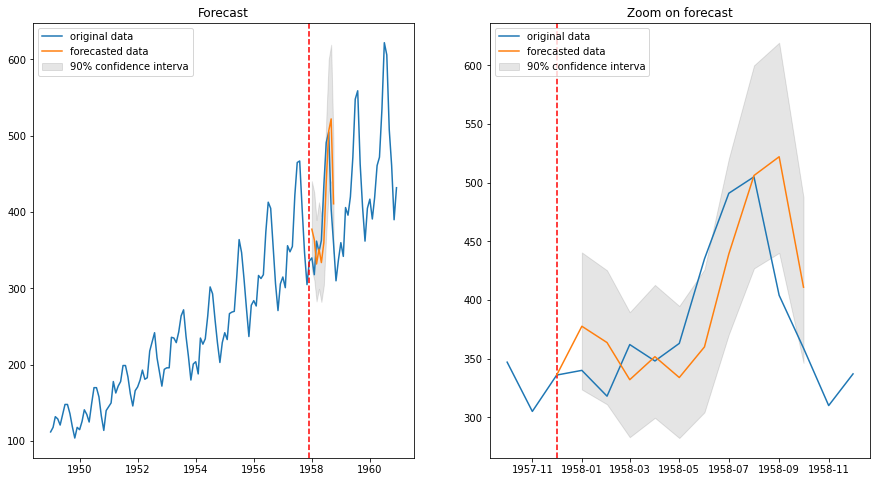

In [49]:
multi_forecast = fitted_model.get_forecast(steps=10).summary_frame(alpha=.1)
multi_forecast = multi_forecast.rename(columns={'mean': 'passengers'})
multi_forecast_intervals = forecast_with_interval(result, multi_forecast)
plot_forecast_interval(multi_forecast_intervals)